# Predicting Earthquakes

Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

There are many ways to compute the magnitude of an earthquake!
A0 is the seismometer reading produced by an Earthquake of standard size (i.e., a calibration earthquake). Generally A0 is 0.001 mm.
This equation assumes that a distance of 100 km separates the seismometer and the epicentre

$ M = log_{10} / (A / A_{0})$

* M = Magnitude
* A = intensity of the earthquake
* $ A_{0} $ = intensity of the earthquake with a magnitude 0

# 2. Data proccessing

## 2.1 Importing necessary modules

In [2]:
import pandas as pd #data preprocessing
import numpy as np #math operations
from catboost import CatBoostRegressor, Pool #machine learning
from sklearn.preprocessing import StandardScaler #data scaling
from sklearn.model_selection import GridSearchCV #hyperparameter optimization
from sklearn.svm import NuSVR, SVR #support vector machine model
from sklearn.kernel_ridge import KernelRidge #kernel ridge model
import matplotlib.pyplot as plt #data visualizations
%matplotlib inline

## 2.2 importing dataset from kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devyangsikotariya","key":"422d93f33739499718292f2a6f63c431"}'}

In [3]:
!mkdir -p ~/.kaggle/ #creating a folder
!mv kaggle.json ~/.kaggle/ #moving the json file
!chmod 600 ~/.kaggle/kaggle.json #changing permission

In [4]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         97           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        208           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        471           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       3238            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      26066            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       6572           False  
connectx

In [5]:
!kaggle competitions download -c LANL-Earthquake-Prediction #downloading the data set

seg_004f1f.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00030f.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_004cd2.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00a37e.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_004314.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_010eab.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00c35b.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00cc91.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00648a.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_004ee5.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00be11.csv: Skip

In [6]:
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## 2.2 Data exploratory

In [3]:
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
#only taking 6 million readings

In [4]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


Visualizing the data

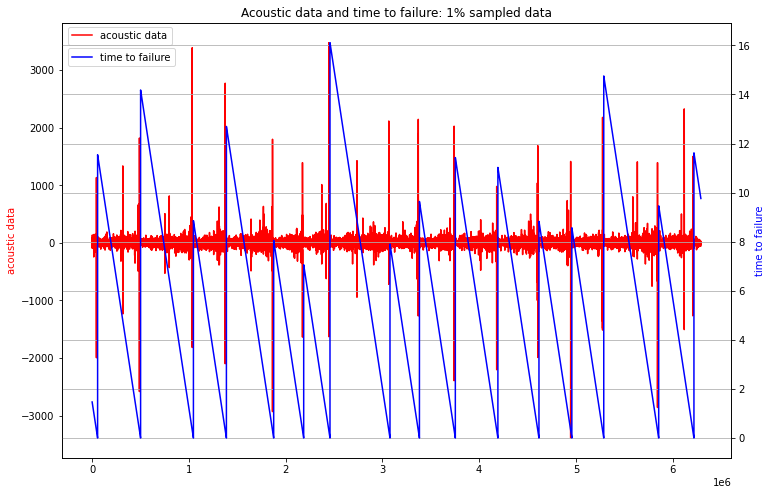

In [5]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

Right before the time to failure (blue line) is the biggest, earthquake happens. So there is a point where, before the spike goes of the earthquake goes up, the accoustic spike goes up before that. That means spike in activity = earthquake.

# 3. Feature Engineering 

There are only 2 features, but we can add more features so that the machine can learn and train well.

In [6]:
# creating a function to generate some statistical features based on the training dataset

def gen_features(X):
    strain = []
    strain.append(X.mean()) #balancing point 
    strain.append(X.std()) #spread of the data
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis()) #whether the data is heavy or light tailed relative to a normal distribution
    strain.append(X.skew()) #asymmetry of our data
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

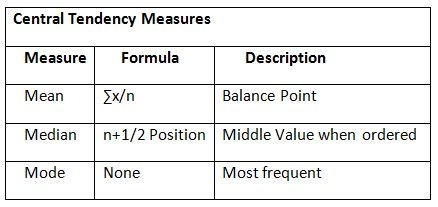




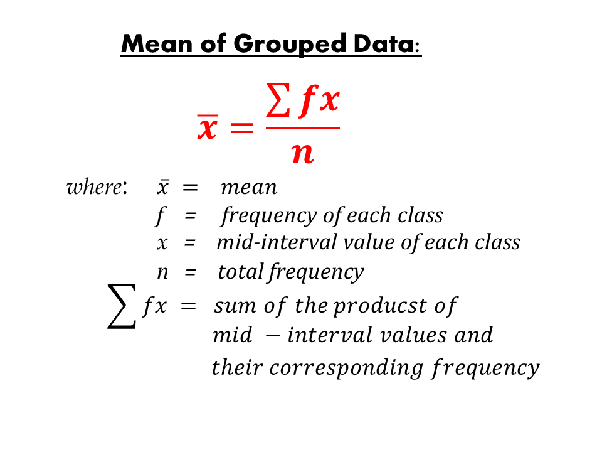

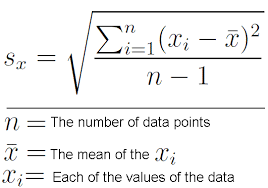

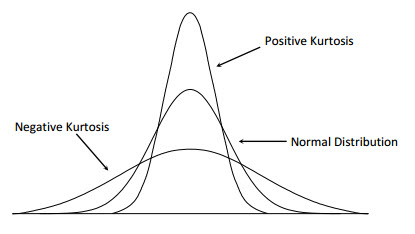


* Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
* Data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers 

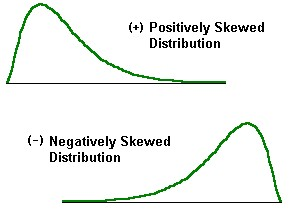

* skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive or negative, or undefined. 

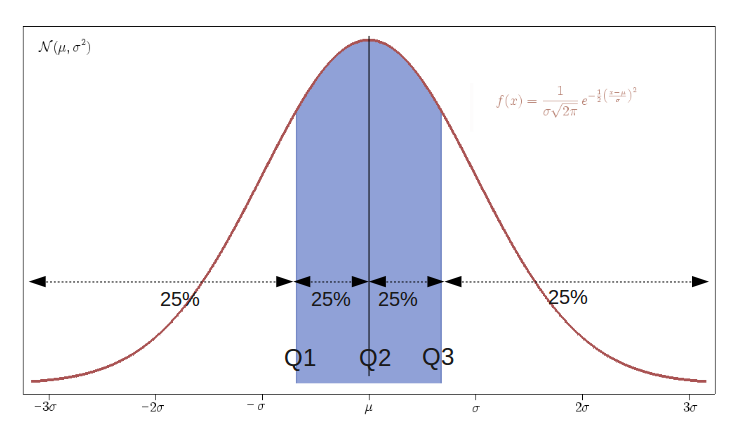

* Quantiles are cut points dividing the range of a probability distribution into continuous intervals with equal probabilities, or dividing the observations in a sample in the same way. 

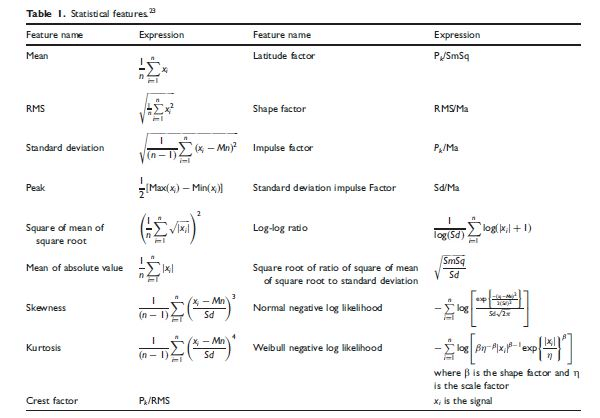

In [17]:
#adding the features
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [18]:
X_train.shape, y_train.shape

((4195, 13), (4195,))

In [19]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,-8.0,-2.0,11.0,18.0,104.0,5.576567,4.333325
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,-11.0,-2.0,12.0,21.0,181.0,5.734167,5.732777
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,-15.0,-3.0,13.0,26.0,140.0,6.152647,5.895945
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,-12.0,-2.0,12.0,22.0,199.0,5.933960,6.061214
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,-15.0,-2.0,12.0,26.0,145.0,6.110587,6.329485


# 4. Implementing Catboost model 


* Yandex is Russian Google
* Yandex uses "gradient boosting" a lot to power their services (music streaming, search, everything really)
* Gradient boosting on decision trees is a form of machine learning that works by progressively training more complex models to maximize the accuracy of predictions.
* It's particularly useful for predictive models that analyze ordered (continuous) data and categorical data.
* It's one of the most efficient ways to build ensemble models. The combination of gradient boosting with decision trees provides state-of-the-art results in many applications with structured data.
* On the first iteration, the algorithm learns the first tree to reduce the training error, shown on left-hand image in figure 1.
* This model usually has a significant error; it’s not a good idea to build very big trees in boosting since they overfit the data.
* The right-hand image in figure 1 shows the second iteration, in which the algorithm learns one more tree to reduce the error made by the first tree.
* The algorithm repeats this procedure until it builds a decent quality model

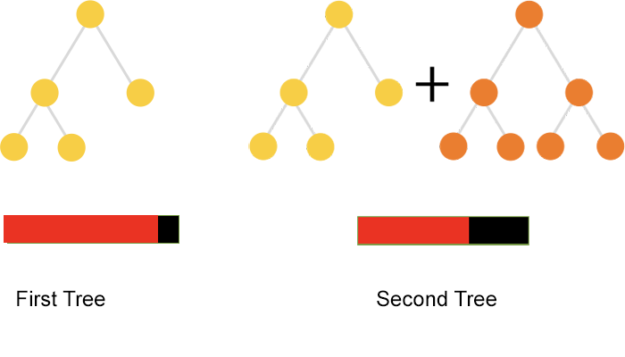



* Gradient Boosting is a way to implement this idea for any continuous objective function.

**Each step of Gradient Boosting combines two steps:**

* Step 1 - Computing gradients of the loss function we want to optimize for each input object
* Step 2 - Learning the decision tree which predicts gradients of the loss function

**ELI5 Time**

* Step 1 - We first model data with simple models and analyze data for errors.
* Step 2 - These errors signify data points that are difficult to fit by a simple model.
* Step 3 - Then for later models, we particularly focus on those hard to fit data to get them right.
* Step 4 - In the end, we combine all the predictors by giving some weights to each predictor.





In [10]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(x_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.3776750114110539}}

# 5. Implement Support Vector Machine + Radial Basis Function Kernel

* A very simple and intuitive way of thinking about kernels (at least for SVMs) is a similarity function.

* Given two objects, the kernel outputs some similarity score. The objects can be anything starting from two integers, two real valued vectors, trees whatever provided that the kernel function knows how to compare them.

* The arguably simplest example is the linear kernel, also called dot-product. Given two vectors, the similarity is the length of the projection of one vector on another.

* Another interesting kernel examples is Gaussian kernel. Given two vectors, the similarity will diminish with the radius of σ. The distance between two objects is "reweighted" by this radius parameter.

* The success of learning with kernels (again, at least for SVMs), very strongly depends on the choice of kernel. You can see a kernel as a compact representation of the knowledge about your classification problem. It is very often problem specific.


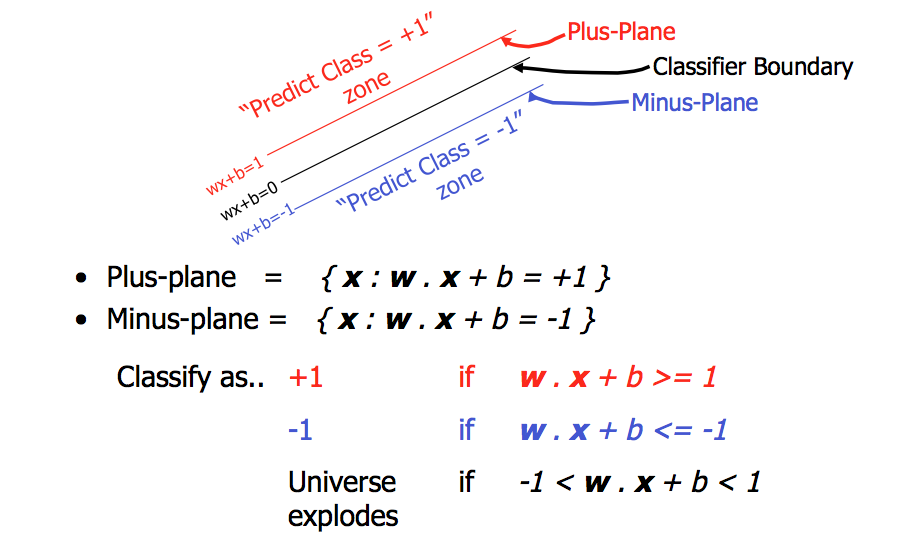

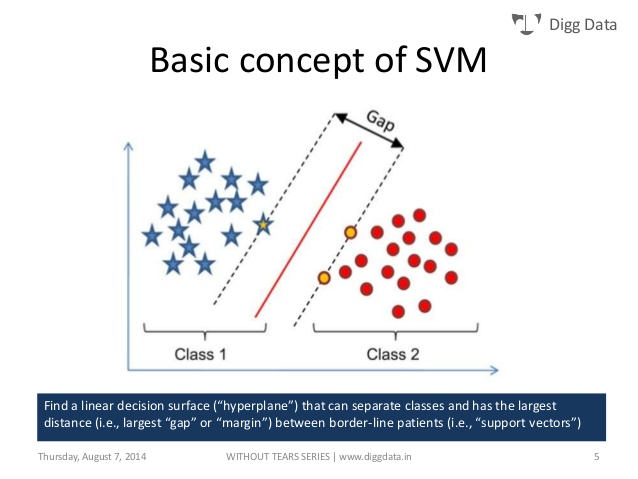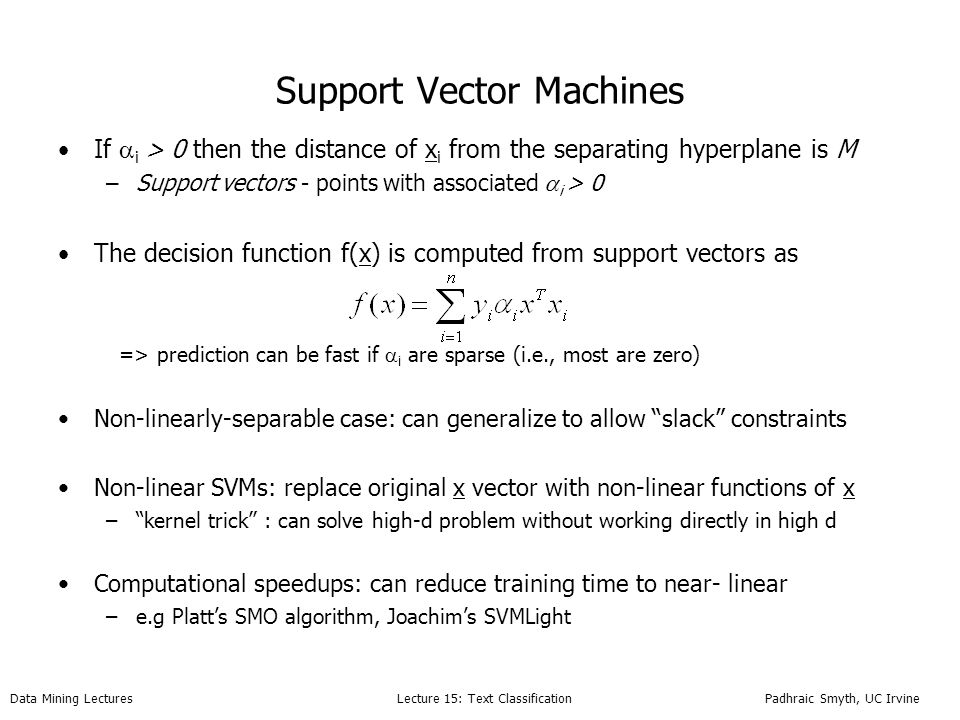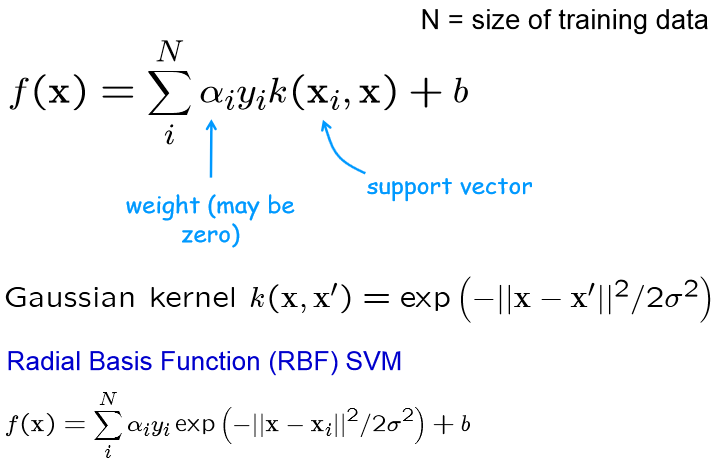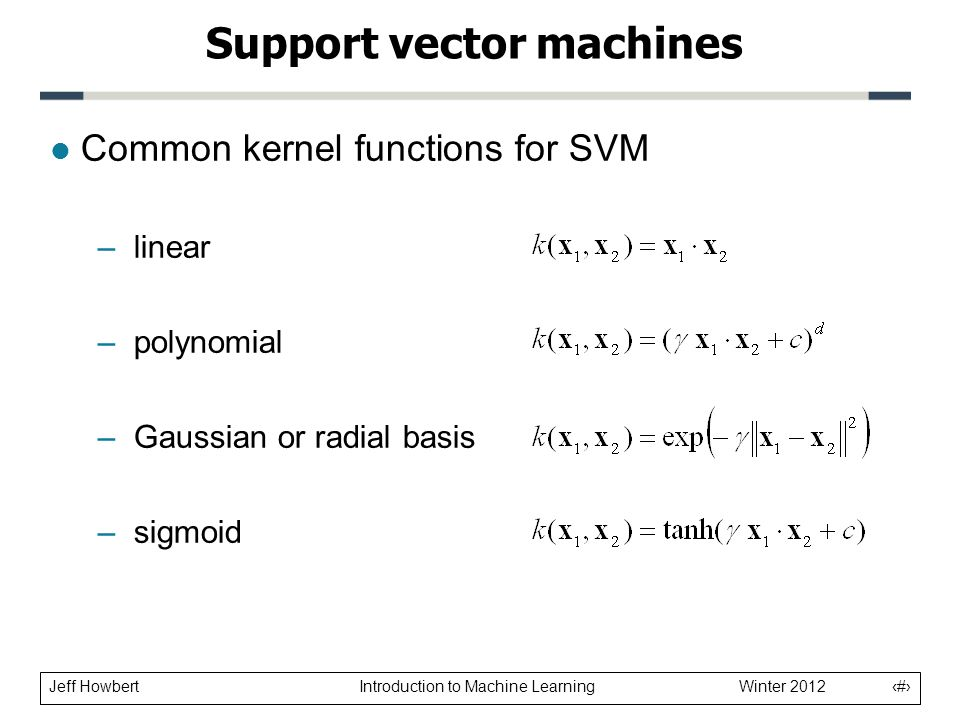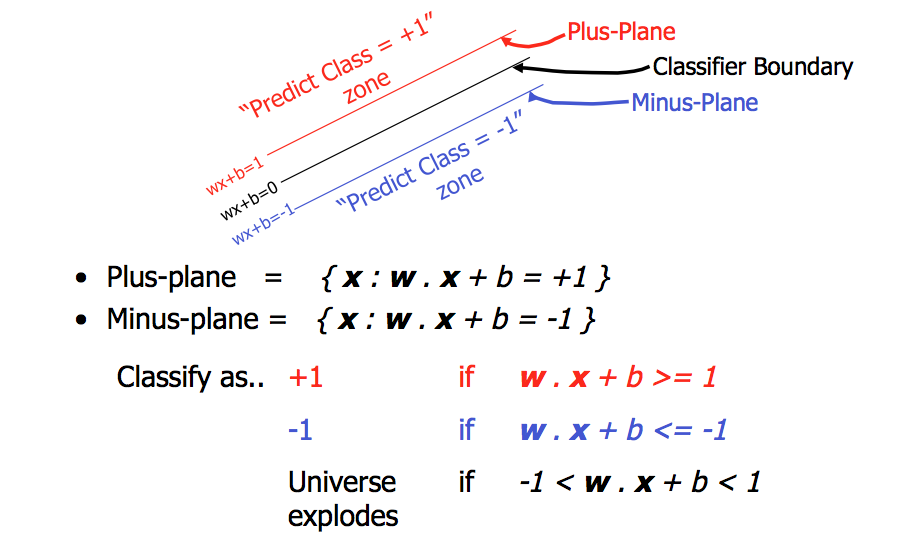

**grid search : pick a bunch of values of α -- (α1,α2,…), pick a bunch of values of β -- (β1,β2,…) and for each pair of values, evaluate the validation error function. Then pick the pair that gives the minimum value of the validation error function.**

In [11]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}


In [22]:
pred = y_pred1[:2624]

In [23]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = pred
submission.to_csv('submission_catboost.csv')